Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far. 

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import csv, sqlite3
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map

In [7]:
con = sqlite3.connect("gdelt.db")

In [8]:
gdelt = pd.read_sql_query("SELECT SQLDATE, Actor1CountryCode, Actor2CountryCode, \
                            Actor1Geo_CountryCode, Actor2Geo_CountryCode, \
                            EventRootCode, AVG(NumMentions), AVG(AvgTone) \
                          FROM gdelt \
                          WHERE SQLDATE > \"2017-05-01\" AND SQLDATE < \"2017-08-01\" \
                          GROUP BY SQLDATE, Actor1CountryCode, Actor2CountryCode, \
                          Actor1Geo_CountryCode, Actor2Geo_CountryCode, EventRootCode", con)
# aggregate data by
# Date Actor1Code Actor2Code Actor1Geo_CountryCode Actor2Geo_CountryCode EventRootCode -> Mean AvgTone

# Features Actor1Code Actor2Code Actor1Geo_CountryCode Actor2Geo_CountryCode NumMentions EventRootCode 

In [198]:
interest = ["SQLDATE",
            "AvgTone", "NumMentions", "EventRootCode",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode"]

categories = ["EventRootCode",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode"]

for category_col in categories:
    gdelt[category_col] = gdelt[category_col].astype('category')
    
gdelt['SQLDATE'] = pd.to_datetime(gdelt['SQLDATE'])  

In [199]:
gdelt = gdelt.drop(labels=gdelt[(gdelt['EventRootCode'] == "--")].index)

In [200]:
gdelt.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4370484 entries, 0 to 4370490
Data columns (total 8 columns):
SQLDATE                  datetime64[ns]
Actor1CountryCode        category
Actor2CountryCode        category
Actor1Geo_CountryCode    category
Actor2Geo_CountryCode    category
EventRootCode            category
AVG(NumMentions)         float64
AVG(AvgTone)             float64
dtypes: category(5), datetime64[ns](1), float64(2)
memory usage: 171.0 MB


In [201]:
gdelt_sample = gdelt.sample(frac=.2)

In [202]:
# standardize data around mean 0 

# split data in missing/non-missing and compare distributions of that data
# which features are generally missing record values

# Try to predict AvgTone 

# SQLDATE                  datetime64[ns]
# Actor1CountryCode        category
# Actor2CountryCode        category
# Actor1Geo_CountryCode    category
# Actor2Geo_CountryCode    category
# EventRootCode            category
# AVG(NumMentions)         float64
# AVG(AvgTone)             float64

In [203]:
def map_missing(x, l, translation):
    if x in l:
        return x
    elif x == "nan":
        return "UNKNOWN"
    else:
        return translation

def unify_rare_cats(data, category, cut_off):
    vc = data[category].value_counts()
    past_cut_off = (vc/len(data)) > cut_off
    remaining = list(vc[past_cut_off].index)
    data[(category + '_unify')] = data[category].astype(str) \
                                                .apply(lambda x: map_missing(x, remaining, "OTHER")) \
                                                .astype('category')

In [204]:
unify_rare_cats(gdelt_sample, 'Actor1CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor2CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor1Geo_CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor2Geo_CountryCode', .005)

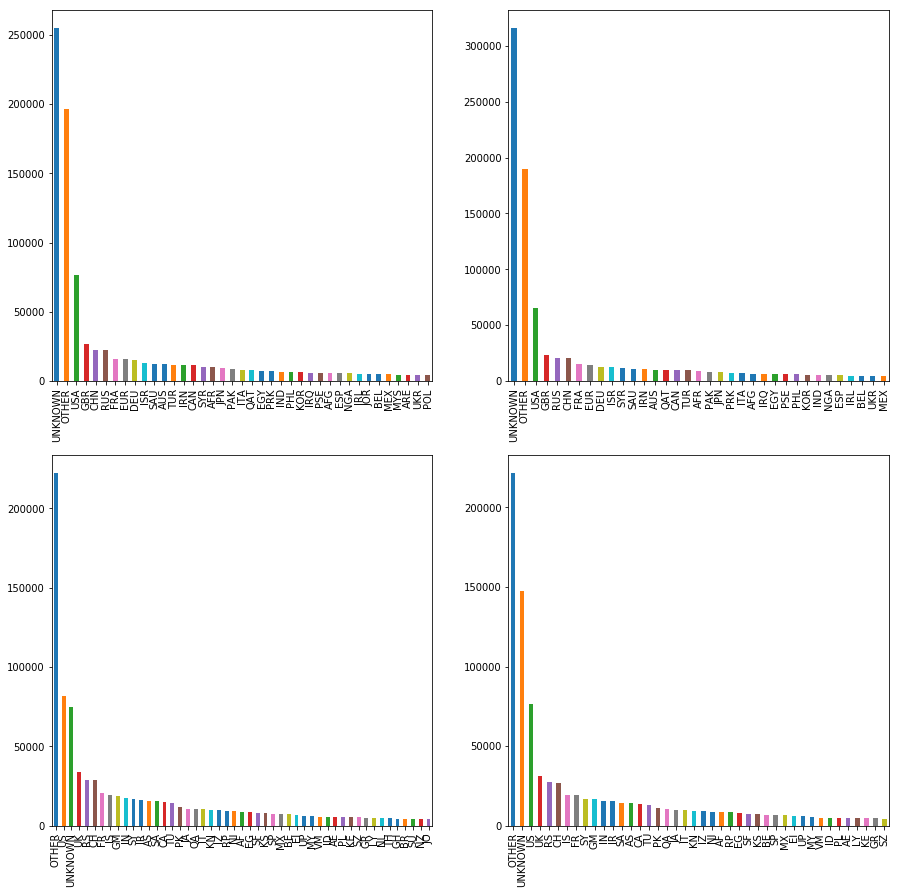

In [205]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))

plt.subplot(221)
gdelt_sample['Actor1CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(222)
gdelt_sample['Actor2CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(223)
gdelt_sample['Actor1Geo_CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(224)
gdelt_sample['Actor2Geo_CountryCode_unify'].value_counts().plot(kind="bar")

In [206]:
gdelt_sample['EventRootCode'].value_counts()

04    187084
01     94390
05     82062
03     71762
02     57693
11     55590
19     52881
17     42915
08     35631
07     33382
06     30998
12     25862
09     19408
13     19258
10     16292
18     16115
16     15164
14     10085
15      6901
20       624
--         0
Name: EventRootCode, dtype: int64

In [208]:
gdelt_sample['norm_NumMentions'] = (gdelt_sample['AVG(NumMentions)'] - gdelt_sample['AVG(NumMentions)'].mean())/ \
                                        gdelt_sample['AVG(NumMentions)'].std()

In [210]:
gdelt_sample['norm_AvgTone'] = (gdelt_sample['AVG(AvgTone)'] - gdelt_sample['AVG(AvgTone)'].mean())/ \
                                        gdelt_sample['AVG(AvgTone)'].std()

In [214]:
Actor1CC_one_hot = pd.get_dummies(gdelt_sample['Actor1CountryCode_unify'], prefix="Actor1CountryCode")
Actor2CC_one_hot = pd.get_dummies(gdelt_sample['Actor2CountryCode_unify'], prefix="Actor2CountryCode")
Actor1CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor1Geo_CountryCode_unify'], prefix="Actor1Geo_CountryCode")
Actor2CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor2Geo_CountryCode_unify'], prefix="Actor2Geo_CountryCode")
EventRoot_one_hot = pd.get_dummies(gdelt_sample['EventRootCode'], prefix="EventRootCode")

one_hot_encoding = pd.concat([Actor1CC_one_hot, Actor2CC_one_hot, Actor1CCGeo_one_hot, 
                              Actor2CCGeo_one_hot, EventRoot_one_hot], axis=1)

In [216]:
gdelt_sample = pd.concat([gdelt_sample, one_hot_encoding], axis=1)

In [230]:
model_columns = list(one_hot_encoding.columns)
model_columns.append('norm_NumMentions')
feature_columns = model_columns.copy()
model_columns.append('norm_AvgTone')

In [222]:
gdelt_sample_m = gdelt_sample[model_columns]

In [228]:
train, test = train_test_split(gdelt_sample_m, test_size=0.25, random_state=42)

In [232]:
regr = linear_model.LinearRegression()
Y = train['norm_AvgTone'].values.reshape(-1, 1)
X = train[feature_columns]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [233]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10 -1.62460666e+10
  -1.62460666e+10 -1.62460666e+10 -1.62460666e+10  7.16217781e+10
   7.16217781e+10  7.16217781e+10  7.16217781e+10  7.16217781e+10
   7.16217781e+10  7.16217781e+10  7.16217781e+10  7.16217781e+10
   7.16217781e+10  7.16217781e+10  7.16217781e+10  7.16217781e+10
   7.16217781e+10  7.16217781e+10  7.16217781e+10  7.16217781e+10
   7.16217781e+10  7.16217781e+10  7.16217781e+10  7.162177

In [260]:
ransac = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression())
Y = train['norm_AvgTone'].values.reshape(-1, 1)
X = train[feature_columns]
ransac.fit(X, Y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [261]:
#print('\nCoefficients: \n', ransac.coef_)
#print('\nIntercept: \n', ransac.intercept_)
print('\nR-squared:')
print(ransac.score(X, Y))


R-squared:
-1.1878379205463898


In [254]:
def compute_RSS(model, data, dependent):
    predictions = model.predict(data)
    squared_residuals = (dependent.values.reshape(-1, 1) - predictions) ** 2
    return squared_residuals.sum()

def compute_TSS(data, dependent):
    return ((dependent.values.reshape(-1, 1) - dependent.values.reshape(-1, 1).mean()) ** 2).sum()

def F_statistic(p, data, model):
    n = len(data)
    RSS = compute_RSS(model, data)
    TSS = compute_TSS(data)
    return ((TSS - RSS) / p) /\
            (RSS / (n - p - 1))

In [250]:
compute_RSS(regr, train[feature_columns], train['norm_AvgTone'])

516754.7841342668

In [251]:
compute_RSS(ransac, train[feature_columns], train['norm_AvgTone'])

1241031.7733438069

In [252]:
compute_RSS(regr, test[feature_columns], test['norm_AvgTone'])

172924.72077743677

In [253]:
compute_RSS(ransac, test[feature_columns], test['norm_AvgTone'])

414723.69992864854

In [257]:
1 - compute_RSS(regr, train[feature_columns], train['norm_AvgTone'])/ \
    compute_TSS(train[feature_columns], train['norm_AvgTone'])

0.21090464835551326

In [258]:
1 - compute_RSS(ransac, train[feature_columns], train['norm_AvgTone'])/ \
    compute_TSS(train[feature_columns], train['norm_AvgTone'])
    
# Well this is a weird outcome for R^2. Implies RSS is greater than TSS.

-0.8950814460853946

In [263]:
gdelt_sample['AvgTone_Pos?'] = gdelt_sample['norm_AvgTone'] > 0

In [275]:
class_model_columns = list(one_hot_encoding.columns)
class_model_columns.append('norm_NumMentions')
feature_columns = class_model_columns.copy()
class_model_columns.append('AvgTone_Pos?')

In [267]:
gdelt_sample_cm = gdelt_sample[class_model_columns]

In [271]:
class_train, class_test = train_test_split(gdelt_sample_cm, test_size=0.25, random_state=42)

In [ ]:
bnb = BernoulliNB()
bnb.fit(class_train[feature_columns], class_train['AvgTone_Pos?'])